In [1]:
import random

from finrl.meta.env_portfolio_allocation import env_portfolio
import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange


In [2]:
def generate_episode(env: gym.Env, policy: Callable, es: bool = False):
    """A function to generate one episode and collect the sequence of (s, a, r) tuples

    This function will be useful for implementing the MC methods

    Args:
        env (gym.Env): a Gym API compatible environment
        policy (Callable): A function that represents the policy.
        es (bool): Whether to use exploring starts or not
    """
    episode = []
    state = env.reset()
    while True:
        if es and len(episode) == 0:
            action = env.action_space.sample()
        else:
            action = policy(state)

        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state

    return episode


In [ ]:
############STUFF GRABBED FROM FINRL TUTORIAL
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys

## 2.4. Create Folders
import os

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

df.head()
df.shape


C:\Users\wacho\Programming\RL_Finance\venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

In [4]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)
df.shape
df.head()

Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,7.116786,7.152143,6.876786,5.898640,1079178800,AAPL,2,0.0,5.903862,5.896146,100.0,-66.666667,100.0,5.898640,5.898640
3483,2008-01-02,46.599998,47.040001,46.259998,33.761406,7934400,AMGN,2,0.0,5.903862,5.896146,100.0,-66.666667,100.0,33.761406,33.761406
6966,2008-01-02,52.090000,52.320000,50.790001,39.588005,8053700,AXP,2,0.0,5.903862,5.896146,100.0,-66.666667,100.0,39.588005,39.588005
10449,2008-01-02,87.570000,87.839996,86.000000,63.481621,4303000,BA,2,0.0,5.903862,5.896146,100.0,-66.666667,100.0,63.481621,63.481621
13932,2008-01-02,72.559998,72.669998,70.050003,45.605480,6337800,CAT,2,0.0,5.903862,5.896146,100.0,-66.666667,100.0,45.605480,45.605480


In [5]:
df.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
83591,2021-10-29,162.130005,162.440002,160.660004,153.936371,1314100,TRV,4,1.424913,156.635661,144.752585,55.691938,130.838082,19.622993,149.630914,150.155366
87074,2021-10-29,454.410004,461.390015,453.059998,447.971100,2497800,UNH,4,12.812443,459.914494,366.732088,67.009715,145.348217,52.064871,406.440819,405.562349
90557,2021-10-29,52.500000,53.049999,52.410000,46.802307,17763200,VZ,4,-0.170568,48.086330,45.189775,46.685018,-39.966419,12.569826,46.875141,47.474614
94040,2021-10-29,46.860001,47.279999,46.770000,41.523605,4999000,WBA,4,-0.169815,44.202650,40.524222,45.913455,-97.394898,0.268701,42.391107,42.889372
97523,2021-10-29,147.910004,150.100006,147.559998,144.852417,7340900,WMT,4,1.795643,147.887261,129.205259,59.710661,130.750253,35.423702,138.057023,140.642312


In [6]:

## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583909,607541200,AAPL,2,-0.082603,3.093651,2.454292,42.254761,-80.462566,16.129793,2.749560,2.861671,"[[0.00134896886695617, 0.00042841240010759493,...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839516,6287200,AMGN,2,0.156756,42.707033,40.853194,51.060605,51.523244,10.432018,41.058034,40.603776,"[[0.00134896886695617, 0.00042841240010759493,...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580751,9625600,AXP,2,-0.935583,18.646872,12.660473,42.554852,-75.437627,25.776759,15.744065,17.616375,"[[0.00134896886695617, 0.00042841240010759493,...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005898,5443100,BA,2,-0.279799,32.174384,28.867833,47.440251,156.995057,5.366299,30.327212,32.389914,"[[0.00134896886695617, 0.00042841240010759493,...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608656,6277400,CAT,2,0.655612,30.348089,25.455648,51.205310,98.374159,26.331746,26.689550,26.423593,"[[0.00134896886695617, 0.00042841240010759493,...",tic AAPL AMGN AXP ...


In [7]:
## Training data split: 2009-01-01 to 2020-07-01
train = data_split(df, '2009-01-01', '2020-07-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)
train.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-01-02,3.067143,3.251429,3.041429,2.747391,746015200,AAPL,4,-0.070153,3.080129,2.452223,45.440192,-32.212842,2.140064,2.750408,2.862473,"[[0.0013661505804949945, 0.0004339380680857294...",tic AAPL AMGN AXP ...
0,2009-01-02,58.590000,59.080002,57.750000,42.737900,6547900,AMGN,4,0.232162,42.852627,40.817723,52.756872,92.828067,0.814217,41.122031,40.691923,"[[0.0013661505804949945, 0.0004339380680857294...",tic AAPL AMGN AXP ...
0,2009-01-02,18.570000,19.520000,18.400000,15.193846,10955700,AXP,4,-0.832049,18.463257,12.644437,43.957548,-42.853099,16.335101,15.742755,17.499520,"[[0.0013661505804949945, 0.0004339380680857294...",tic AAPL AMGN AXP ...
0,2009-01-02,42.799999,45.560001,42.779999,33.941105,7010200,BA,4,-0.002007,32.948630,28.452124,50.822053,272.813024,20.494464,30.469477,32.344130,"[[0.0013661505804949945, 0.0004339380680857294...",tic AAPL AMGN AXP ...
0,2009-01-02,44.910000,46.980000,44.709999,31.093401,7117200,CAT,4,0.833184,30.850188,25.434764,53.661259,129.524706,34.637448,26.926402,26.424174,"[[0.0013661505804949945, 0.0004339380680857294...",tic AAPL AMGN AXP ...


In [8]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
e_train_gym_two = StockPortfolioEnv(df = train, **env_kwargs)
e_train_gym_three = StockPortfolioEnv(df = train, **env_kwargs)


Stock Dimension: 28, State Space: 28


(28, 18)
AAPL
[3.067142963409424]
AMGN
[58.59000015258789]
AXP
[18.56999969482422]
BA
[42.79999923706055]
CAT
[44.90999984741211]
CRM
[8.024999618530273]
CSCO
[16.40999984741211]
CVX
[74.2300033569336]
DIS
[22.760000228881836]
GS
[84.0199966430664]
HD
[23.06999969482422]
HON
[31.394458770751953]
IBM
[80.20076751708984]
INTC
[14.6899995803833]
JNJ
[60.130001068115234]
JPM
[31.190000534057617]
KO
[22.700000762939453]
MCD
[62.380001068115234]
MMM
[57.54999923706055]
MRK
[29.064884185791016]
MSFT
[19.530000686645508]
NKE
[12.737500190734863]
PG
[61.689998626708984]
TRV
[45.2599983215332]
UNH
[26.700000762939453]
VZ
[32.00077438354492]
WBA
[24.649999618530273]
WMT
[55.97999954223633]


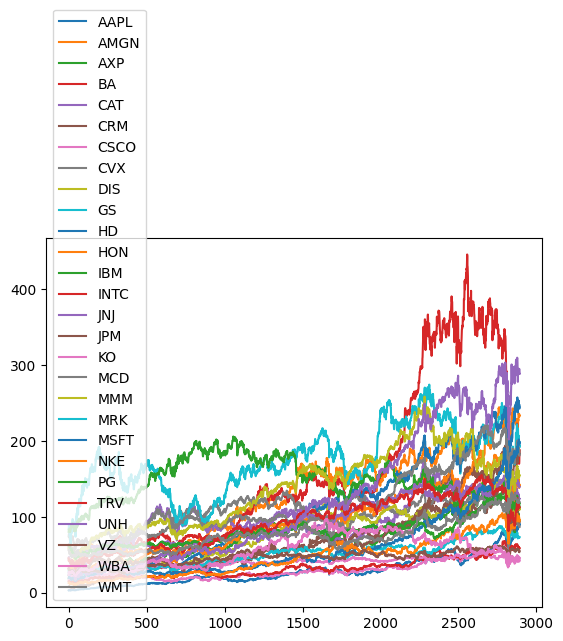

In [9]:
print(e_train_gym_three.data.shape)
for ticker in e_train_gym_three.data['tic'].unique():
    print(ticker)
    
    print(e_train_gym_three.data[e_train_gym_three.data['tic'] == ticker]['open'].tolist())
    plt.plot(e_train_gym_three.df[e_train_gym_three.df['tic'] == ticker]['open'].tolist(), label=ticker)
plt.legend(loc='lower left')

In [10]:
e_train_gym_three.data[['tic','open']]
for row in e_train_gym_three.data[['tic','open']].values:
    print({row[0]: row[1]})
    
print(e_train_gym_three.data['open'] - e_train_gym_three.data['open'])


{'AAPL': 3.067142963409424}
{'AMGN': 58.59000015258789}
{'AXP': 18.56999969482422}
{'BA': 42.79999923706055}
{'CAT': 44.90999984741211}
{'CRM': 8.024999618530273}
{'CSCO': 16.40999984741211}
{'CVX': 74.2300033569336}
{'DIS': 22.760000228881836}
{'GS': 84.0199966430664}
{'HD': 23.06999969482422}
{'HON': 31.394458770751953}
{'IBM': 80.20076751708984}
{'INTC': 14.6899995803833}
{'JNJ': 60.130001068115234}
{'JPM': 31.190000534057617}
{'KO': 22.700000762939453}
{'MCD': 62.380001068115234}
{'MMM': 57.54999923706055}
{'MRK': 29.064884185791016}
{'MSFT': 19.530000686645508}
{'NKE': 12.737500190734863}
{'PG': 61.689998626708984}
{'TRV': 45.2599983215332}
{'UNH': 26.700000762939453}
{'VZ': 32.00077438354492}
{'WBA': 24.649999618530273}
{'WMT': 55.97999954223633}
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0  

In [13]:
from typing import Sequence
from enum import Enum
import random
from itertools import product
def random_agent(env: StockPortfolioEnv, iter=2000):
    env.reset()
    for iteration in range(iter):
        action = [0] * len(env.action_space.sample())
        action[random.randint(0,  len(env.action_space.sample()) - 1)] = 1
        state, reward, terminal, _, _ = env.step(action)
    return env
def argmax(arr: Sequence[float]) -> int:
    """Argmax that breaks ties randomly

    Takes in a list of values and returns the index of the item with the highest value, breaking ties randomly.

    Note: np.argmax returns the first index that matches the maximum, so we define this method to use in EpsilonGreedy and UCB agents.
    Args:
        arr: sequence of values
    """
    largest = max(arr)
    in_case_of_ties = []
    for i in range(len(arr)):
        if arr[i] == largest:
            in_case_of_ties.append(i)
    return random.choice(in_case_of_ties)

def create_epsilon_policy(Q: defaultdict, epsilon: float, actions) -> Callable:
    """Creates an epsilon soft policy from Q values.

    A policy is represented as a function here because the policies are simple. More complex policies can be represented using classes.

    Args:
        Q (defaultdict): current Q-values
        epsilon (float): softness parameter
    Returns:
        get_action (Callable): Takes a state as input and outputs an action
    """
    # Get number of actions
    num_actions = len(Q[0])

    def get_action(state: Tuple) -> int:
        # You can reuse code from ex1
        # Make sure to break ties arbitrarily
        a_star = argmax(Q[state])
        
        if np.random.random() < epsilon:
            action = random.choice(actions)
        else:
            probabilities = [(1 -epsilon + (epsilon/num_actions)) if a == a_star else epsilon / num_actions for a in actions]
            return np.random.choice(actions, p=probabilities)

        return action

    return get_action


class PortfolioAction(Enum):
    BUY = 0
    SELL = 1
    HOLD = 2
    

def convert_prices_to_discrete_state(prev_data_df: pd.DataFrame, current_data_df: pd.DataFrame) -> Tuple:
    if prev_data_df['tic'] != current_data_df['tic']:
        raise IndexError("Dfs are wrong")
    percent_diffs = ((current_data_df['open'] - prev_data_df['open']) / prev_data_df['open']) * 100
    
    discrete = []
    for dif in percent_diffs.values:
        if dif > 5:
            discrete.append(0)
        elif 5 > dif > 0:
            discrete.append(1)
        elif 0 > dif > -5:
            discrete.append(2)
        elif -5 > dif:
            discrete.append(3)
        else:
            discrete.append(4)
    return tuple(discrete)

def discrete_action_to_portfolio(list_of_actions: PortfolioAction, current_portfolio: tuple):
    buy_indexes = []
    sell_indexes = []
    
    updated_portfolio = [val for val in current_portfolio]
    # get indexes
    for idx, action in enumerate(list_of_actions):
        if action == PortfolioAction.BUY:
            buy_indexes.append(idx)
        elif action == PortfolioAction.SELL:
            sell_indexes.append(idx)
        else:
            continue
    
    if len(buy_indexes) == 0 or len(sell_indexes) == 0:
        # cannot buy or sell without doing both in order to keep all capital deployed
        # doesn't reflect actual action space but an initial naive approach
        return current_portfolio
            
    
    # determine how much of the portfolio weight we are shifting
    sold_percent = sum([current_portfolio[index] for index in sell_indexes])
    
    
    # distribute portfolio weight
    distribute_percent = sold_percent / float(len(buy_indexes))
    
    for index in buy_indexes:
        updated_portfolio[index] += distribute_percent
    for index in sell_indexes:
        updated_portfolio[index] = 0.0
    return tuple(updated_portfolio)

def tabular_agent(env: StockPortfolioEnv, epsilon, step_size, gamma, iter):
    env.reset()
    print("ENV RESET")
    actions = list(product(PortfolioAction, repeat=28))
    print("ACTIONS MADE")
    current_data = env.data
    # take single step to have data in prev
    state, reward, terminal, _, _ = env.step([1] * 28)
    prev_data = current_data
    current_data = env.data
    
    
    Q = defaultdict(lambda: np.zeros(len(actions)))
    policy = create_epsilon_policy(Q, epsilon, actions)

    # run SARSA for iterations
    env.reset()
    S = convert_prices_to_discrete_state(prev_data, current_data)
    A = policy(S)
    episode = []
    
    for _ in range(iter):
        next_state, reward, terminal, _, _ = env.step(discrete_action_to_portfolio(A, env.actions_memory[-1]))
        episode.append((S, A, reward))
        S = convert_prices_to_discrete_state(prev_data, current_data)
        A_star = policy(S)
        Q[S][A] = Q[S][A] + (step_size * (reward + (gamma * Q[next_state][A_star]) - Q[S][A]))
        S = next_state
        A = A_star
        if terminal:
            break

    return env

    

In [12]:
env_after_training = random_agent(e_train_gym)

In [ ]:
other_agent_env = tabular_agent(e_train_gym_two,  gamma=0.5, epsilon=0.1, step_size=0.5, iter=2)
